## 1. Alien vs Predator 데이터셋
[Alien vs Predator 데이터셋](https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images﻿)은 컴퓨터 비전과 이미지 분류 모델을 학습시키기 위해 제공되는 소규모 데이터셋입니다. 이 데이터셋은 영화 속 캐릭터인 에일리언(Alien)과 프레데터(Predator)의 이미지로 구성되어 있습니다. 이 데이터를 통해 이 두 클래스를 분류하는 이미지 분류 모델을 학습시킬 수 있습니다.

In [2]:
from google.colab import files
files.upload()  # kaggle.json 업로드 창 표시
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [3]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images

Dataset URL: https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
License(s): ODbL-1.0
  0% 0.00/14.1M [00:00<?, ?B/s]
100% 14.1M/14.1M [00:00<00:00, 1.10GB/s]


In [4]:
# !unzip -q alien-vs-predator-images.zip

## 2. Alexnet 모델을 활용한 Alien vs Predator 분류

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [7]:
data_transforms ={
    'train':transforms.Compose([
        # PyTorch에서 AlexNet를 224사이즈로 변형해서 받음
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10,scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation':transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
}

In [8]:
def target_transforms(target):
    return torch.FloatTensor([target])

In [9]:
image_datasets ={
    'train': datasets.ImageFolder('data/train',data_transforms['train'],target_transform = target_transforms),
    'validation': datasets.ImageFolder('data/validation',data_transforms['validation'],target_transform = target_transforms)
}

In [10]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

In [11]:
print(len(image_datasets['train']), len(image_datasets['validation']))

694 200


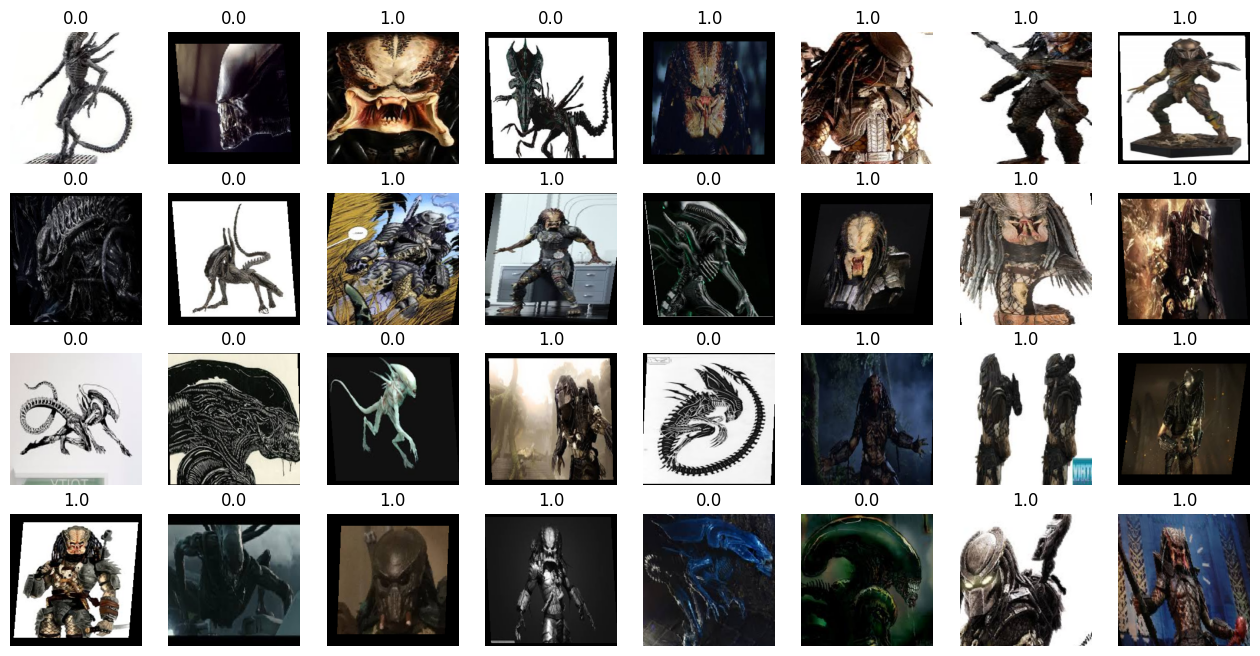

In [12]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0)) # (3, 224, 224) -> (224, 224, 3)
    ax.set_title(label.item())
    ax.axis('off')

## 3. 전이 학습
전이 학습(Transfer Learning)은 이미 학습된 모델(주로 대규모 데이터셋에서 사전 학습된 딥러닝 모델)을 새로운 문제에 적용하여 학습 시간을 단축하고 성능을 향상시키는 방법입니다. 기존 모델이 학습한 특징(Feature)을 활용해, 새로운 데이터셋에서 모델의 일부(주로 마지막 레이어)만 다시 학습하거나 추가 학습(Fine-tuning)을 진행합니다. 이는 특히 데이터가 적거나 학습 리소스가 제한된 상황에서 효과적이며, 이미지 분류(예: ResNet, VGG), 자연어 처리(예: BERT, GPT) 등 다양한 분야에서 널리 사용됩니다.

<img src="https://blog.kakaocdn.net/dna/w0qUR/btsPCTjwXUF/AAAAAAAAAAAAAAAAAAAAAL0WWOvKILqSodi6IfmTRUVl3yeqDi4INjmo0IT3TaWw/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1753973999&allow_ip=&allow_referer=&signature=chDwRH7gZ2ZF8OrmhFcfbU8jLvI%3D">

In [13]:
model = models.alexnet(weights='IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 78.8MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### ※ 이미지넷

> 이미지넷(ImageNet)은 대규모 이미지 데이터셋으로, 컴퓨터 비전 연구와 딥러닝 모델 학습에 널리 사용됩니다. 2009년 스탠포드 대학의 페이페이 리(Fei-Fei Li) 교수팀이 구축했으며, 약 1,400만 장의 이미지와 22,000개 이상의 카테고리로 구성되어 있습니다. 이 중, 가장 널리 사용되는 ILSVRC(Imagenet Large Scale Visual Recognition Challenge) 버전은 약 1,000개의 클래스와 120만 장의 이미지를 포함합니다. 이미지넷은 모델이 객체를 분류하고 특징을 학습하는 데 필요한 풍부한 데이터와 레이블을 제공하며, ResNet, VGG, Inception 등 여러 혁신적인 모델이 이미지넷 대회를 통해 개발되었습니다. 이 데이터셋은 특히 사전 학습(Transfer Learning)에서 중요한 역할을 하며, 딥러닝 연구의 표준 벤치마크로 자리 잡았습니다.

In [14]:
for param in model.parameters():
    param.requires_grad = False # 가져온 파라미터를 업데이트 하지 않음

### ※ Model Freezing

> Model Freezing은 전이 학습(Transfer Learning)에서 사전 학습된 모델의 일부 또는 전체 계층의 가중치를 고정하여 학습되지 않도록 설정하는 기법입니다. 주로 사전 학습된 모델의 초기 계층(Convolutional Layers 등)은 일반적인 특징(예: 가장자리, 패턴)을 학습했으므로 고정하고, 새로운 데이터셋에 특화된 특징을 학습하기 위해 최상위 계층(분류 헤드 등)만 학습합니다. 이 방법은 학습할 가중치의 수를 줄여 계산 비용을 절감하고, 과적합을 방지하며, 데이터가 부족한 상황에서 특히 유용합니다. 필요에 따라, 초기 학습이 끝난 후 일부 계층을 고정 해제(Fine-Tuning)하여 모델을 더 정교하게 조정할 수도 있습니다.

- 즉, Conv Layer은 고정 + FC Layer만 수정

In [15]:
model.classifier = nn.Sequential(
    nn.Linear(256 * 6 * 6, 128),
    nn.ReLU(),
    nn.Linear(128,1),
    nn.Sigmoid()
).to(device)

print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_featur

In [17]:
optimizer = optim.Adam(model.classifier.parameters(),lr=0.001)

epochs= 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()        # 테스트 모드

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)
            # 0 아니면 1이기때문에 BCE 사용
            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10 Loss: 0.5293 Accuracy: 72.59%
validation: Epoch    1/10 Loss: 0.2782 Accuracy: 89.29%
train     : Epoch    2/10 Loss: 0.2420 Accuracy: 88.57%
validation: Epoch    2/10 Loss: 0.2208 Accuracy: 91.96%
train     : Epoch    3/10 Loss: 0.2031 Accuracy: 90.37%
validation: Epoch    3/10 Loss: 0.2364 Accuracy: 87.50%
train     : Epoch    4/10 Loss: 0.1786 Accuracy: 92.42%
validation: Epoch    4/10 Loss: 0.2681 Accuracy: 87.50%
train     : Epoch    5/10 Loss: 0.1162 Accuracy: 95.74%
validation: Epoch    5/10 Loss: 0.2316 Accuracy: 87.95%
train     : Epoch    6/10 Loss: 0.1027 Accuracy: 96.73%
validation: Epoch    6/10 Loss: 0.2265 Accuracy: 89.29%
train     : Epoch    7/10 Loss: 0.1127 Accuracy: 95.53%
validation: Epoch    7/10 Loss: 0.2390 Accuracy: 89.29%
train     : Epoch    8/10 Loss: 0.0812 Accuracy: 97.09%
validation: Epoch    8/10 Loss: 0.1693 Accuracy: 91.07%
train     : Epoch    9/10 Loss: 0.0549 Accuracy: 98.72%
validation: Epoch    9/10 Loss: 0.1715 Accuracy:

In [16]:
from PIL import Image

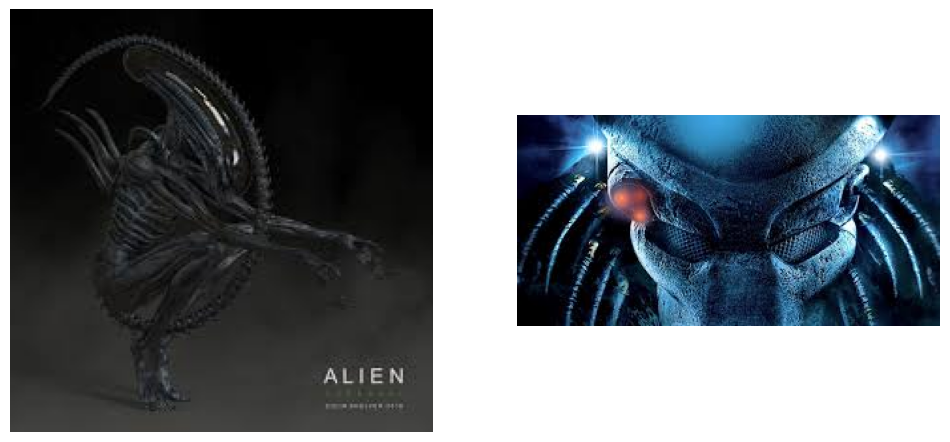

In [18]:
img1 = Image.open('/content/alien_vs_predator_thumbnails/data/validation/alien/37.jpg')
img2 = Image.open('/content/alien_vs_predator_thumbnails/data/validation/predator/35.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [19]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [20]:
# 따로노는 이미지를 stack으로 쌓아서 이미지가 2개인 batch가 됌
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [21]:
y_pred = model(test_batch)
y_pred

tensor([[0.0010],
        [0.9917]], grad_fn=<SigmoidBackward0>)

(np.float64(-0.5), np.float64(317.5), np.float64(158.5), np.float64(-0.5))

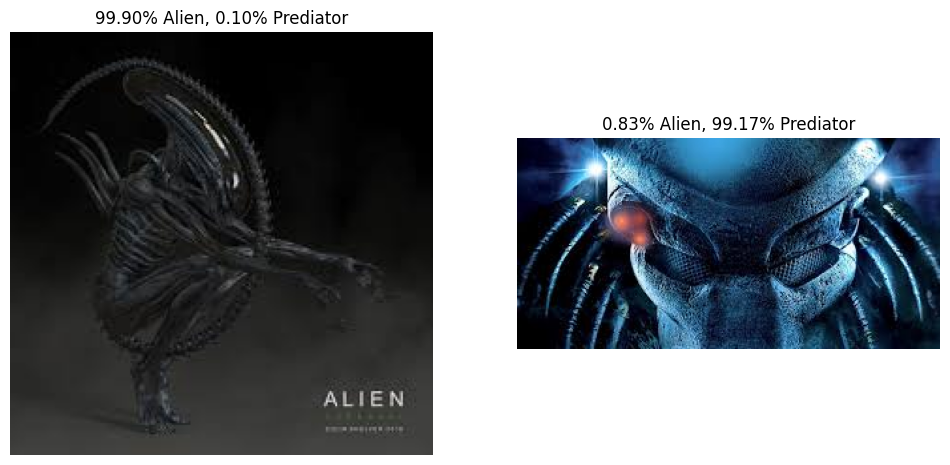

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0])*100:.2f}% Alien, {(y_pred[0, 0])*100:.2f}% Prediator')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1, 0])*100:.2f}% Alien, {(y_pred[1, 0])*100:.2f}% Prediator')
axes[1].imshow(img2)
axes[1].axis('off')